## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners 
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

In [2]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Here we calc the camera distortion coefficients and camera matrix
def cal_undistort(img):
    # Use cv2.calibrateCamera() and cv2.undistort()
    #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

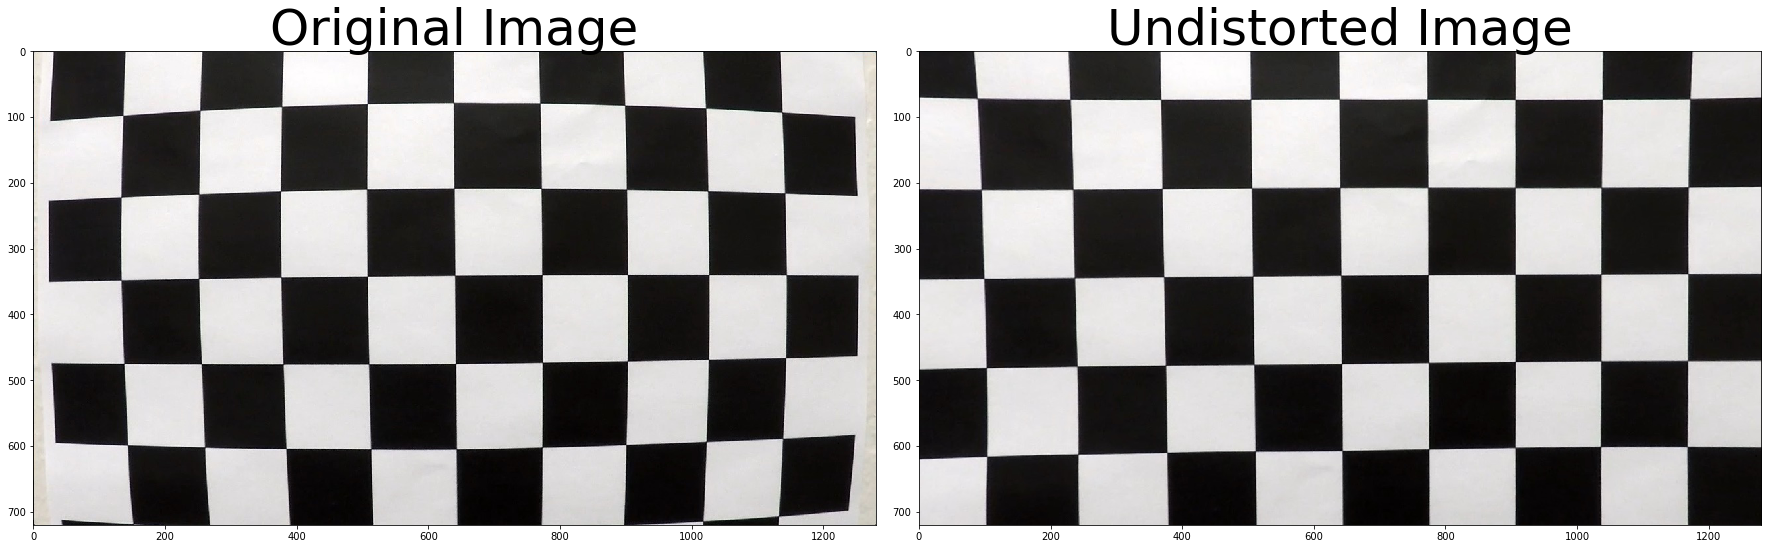

In [3]:
# Lets see the result on the first calibration image
img = mpimg.imread('camera_cal/calibration1.jpg')

undistorted = cal_undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Here I'll create a binary image with the likely lane lines

In [60]:
# First we will load all the test_images undistorted and ensure the directories exists
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

ensure_dir("output_images/")
ensure_dir("output_images/binary/")
ensure_dir("output_images/birdeye/")
ensure_dir("output_images/warped/")
ensure_dir("output_images/undistorted/")

test_images = {}
for file in os.listdir("test_images/"):
    img = mpimg.imread('test_images/' + file)
    undistorted = cal_undistort(img)
    test_images[file] = undistorted
    plt.imsave('output_images/undistorted/' + file, undistorted)

In [5]:
# A pipeline for creating a binary image with likely images
def binary_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

In [6]:
# here we process each test_image with the binary pipeline
binary_images = {}
for file_name in test_images.keys():
    binary_result = binary_pipeline(test_images[file_name])
    binary_images[file_name] = binary_result
    plt.imsave('output_images/binary/' + file_name, binary_result, cmap='gray')

In [7]:
## Next we define class for getting a bird-eye view and transformin it back. 
class BirdEye:
    src = np.float32([[268,676], \
                      [582,460], \
                      [705,460], \
                      [1043,676] \
                     ])
    dst = np.float32([[268,676], \
                      [268,0], \
                      [1043,0], \
                      [1043,676] \
                     ])
    def __init__(self):
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
    def warp(self, img):
        w = img.shape[1]
        h = img.shape[0]
        img_size = (w, h)
        warped = cv2.warpPerspective(img, self.M, img_size, flags=cv2.INTER_LINEAR)
        return warped
    def unwarp(self, img):
        w = img.shape[1]
        h = img.shape[0]
        img_size = (w, h)
        unwarped = cv2.warpPerspective(img, self.M, img_size, flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
        return unwarped


In [8]:
# here we transform each image to bird eye
be = BirdEye()
warped_images = {}
for file_name in binary_images.keys():
    be_result = be.warp(binary_images[file_name])
    warped_images[file_name] = be_result
    plt.imsave('output_images/birdeye/' + file_name, be_result, cmap='gray')

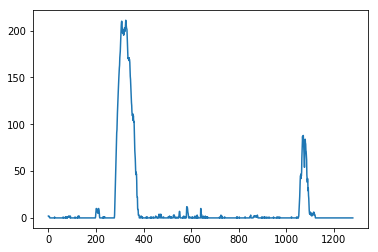

In [9]:
# Sample histogram of an image
binary_warped = warped_images['test3.jpg']

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [49]:
# This function finds lane_lines initially when we don't have previous data
def find_lanes_init(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result. Used for debuging
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    center = np.int(binary_warped.shape[1]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                           (nonzerox < center) & \
                           (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                           (nonzerox > center) & \
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #Visualization
    # Generate x and y values for plotting
    #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)

    return left_fit, right_fit

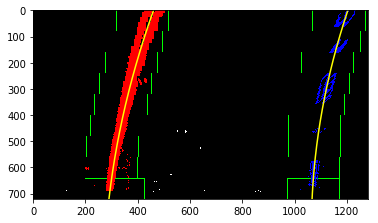

In [22]:
warped_image = warped_images['test3.jpg']
t1,t2 = find_lanes_init(warped_image)

In [50]:
# lanes polynomal with data from previous images

def find_lanes(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    center = np.int(binary_warped.shape[1]/2)
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & \
                        (nonzerox < center) & \
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & \
                        (nonzerox > center) & \
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit


## Test on Videos

In [54]:
# This is the function to process the video images
class Worker:
    left_fit = []
    right_fit = []
    last_found = False
    def __init__(self):
        self.be = BirdEye()
    def pipeline(self, img):
        # Undistort
        undistorted = cal_undistort(img)
        # Create binary image with filters
        binary_image = binary_pipeline(undistorted)
        # Warp to birdeye
        binary_warped = self.be.warp(binary_image) # 'be' sould be init globaly
        
        left_fit  = self.left_fit
        right_fit = self.right_fit

        #If we don't have previous finding we try to find initial
        if not self.last_found:
            left_fit, right_fit = find_lanes_init(binary_warped)
        else:
            left_fit, right_fit = find_lanes(binary_warped, left_fit, right_fit)
            
        # Find curvature
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        y_eval = np.max(ploty)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        curv = np.int((left_curverad + right_curverad) / 2)
        offset = (img.shape[1]/2 - ((right_fitx[-1] - left_fitx[-1]) / 2 + left_fitx[-1])) * xm_per_pix
        
        #Sanity Checks?
        self.left_fit = left_fit
        self.right_fit = right_fit
        self.last_found = True
        
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = self.be.unwarp(color_warp) 
        # Combine the result with the original image
        result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(result, ('Radius of curvature %d m' % curv), (10, 30), font, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(result, ('Offset from center of lane lane is %0.2f m' % offset), (10, 60), font, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
        return result

In [61]:
work = Worker()
for file in os.listdir("test_images/"):
    img = mpimg.imread('test_images/' + file)
    result = work.pipeline(img)
    work.last_found = False
    plt.imsave('output_images/' + file, result)

In [55]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [56]:
# Init
ensure_dir('videos_output/')
work = Worker()
def process_image(image):
    return work.pipeline(image)

video_output = 'videos_output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image) 
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video videos_output/project_video.mp4
[MoviePy] Writing video videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [04:04<00:00,  5.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_output/project_video.mp4 

CPU times: user 3min 44s, sys: 1min 2s, total: 4min 46s
Wall time: 4min 5s
